### DQN _ cartpole using pytorch

In [1]:
import math, random
import retro

import torch

import torch.nn as nn

import torch.optim as optim

import torch.autograd as autograd

import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import gym



In [2]:
use_cuda=torch.cuda.is_available()

Variable = lambda * args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if use_cuda else autograd.Variable(*args, **kwargs)



In [3]:
from collections import deque

class ReplayBuffer(object): 
    
    def __init__(self, capacity):
        
        self.buffer =deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        
        state = np.expand_dims(state, 0)
        
        next_state = np.expand_dims(next_state, 0)
        
        self.buffer.append((state,action,reward,next_state, done))
                           
    def sample(self, batch_size):
        
        state,action,reward,next_state, done = zip(*random.sample(self.buffer, batch_size))
        
        return np.concatenate(state), action, reward, np.concatenate(next_state), done 
                           
    def __len__(self):
        return len(self.buffer)

In [4]:
env= gym.make("CartPole-v0")

In [5]:
epsilon_state = 1.0

epsilon_final = 0.01 
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx : epsilon_final+(epsilon_state - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

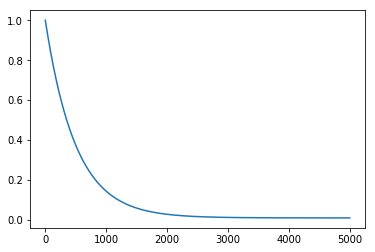

In [6]:
plt.plot([epsilon_by_frame(frame_idx) for frame_idx in range(5000)])

In [7]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0],128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
            
        )
    
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        
        if random.random() > epsilon : 
            state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile = True)
            print("state is ", state)
            q_value = self.forward(state)
            
            action = q_value.max(1)[1].data[0]
            print("action is", action)
            
        else : 
            action = random.(env.action_space.n)

            
            print("epsilon action is ", action)
        return action
    
        
    

In [8]:
model = DQN(env.observation_space, env.action_space.n)


if use_cuda:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())


replaymemory = ReplayBuffer(10000)


In [9]:
def compute_td_loss(batch_size):
    
    state, action, reward, next_state, done =replaymemory.sample(batch_size)
    
    state = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    reward = Variable(torch.FloatTensor(reward))
    action = Variable(torch.LongTensor(action))
    done = Variable(torch.FloatTensor(done))
    
    q_values = model(state)
    next_q_values = model(next_state)
    
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    next_q_value = next_q_values.max(1)[0]
    
    expected_q_value = reward  + gamma*next_q_value * (1- done)
    
    # let's change
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    
    optimizer.zero_grad()
    
    loss.backward()
    
    
    optimizer.step()
    
    return loss

In [52]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize = (20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.plot(losses)
    plt.show()
    

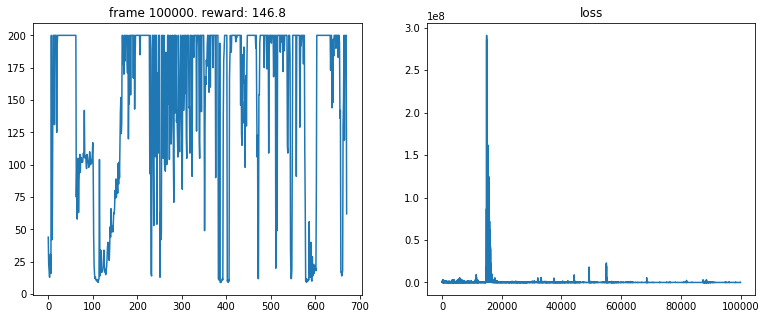

In [15]:
num_episodes = 100000
batch_size = 32

gamma= 0.99

losses= []

all_rewards = []

episode_reward = 0


state =env.reset()

for frame_idx in range( num_episodes + 1): 
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state,  reward, done, _ = env.step(action)
    replaymemory.push(state, action, reward, next_state, done )
    
    state= next_state
    
    episode_reward += reward
    
    if done : 
        state= env.reset()
        all_rewards.append(episode_reward)
        episode_reward=0
        
    if len(replaymemory) > batch_size: 
        loss= compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 10 == 0:
        plot(frame_idx, all_rewards, losses)
    


### 흠.. 리워드의 바운드가 굉장히 큰데? 왜그럴까? 리플레이 메모리를 늘려볼까>>

In [17]:
replaymemory= ReplayBuffer(20000)


In [19]:
print(replaymemory)

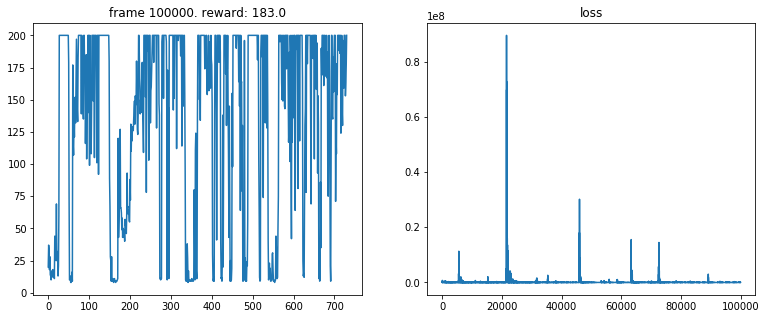

In [20]:
num_episodes = 100000
batch_size = 32

gamma= 0.99

losses= []

all_rewards = []

episode_reward = 0


state =env.reset()

for frame_idx in range( num_episodes + 1): 
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state,  reward, done, _ = env.step(action)
    replaymemory.push(state, action, reward, next_state, done )
    
    state= next_state
    
    episode_reward += reward
    
    if done : 
        state= env.reset()
        all_rewards.append(episode_reward)
        episode_reward=0
        
    if len(replaymemory) > batch_size: 
        loss= compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 10 == 0:
        plot(frame_idx, all_rewards, losses)
    


음.. 크게 다른걸 모르겠는데 ㅠ

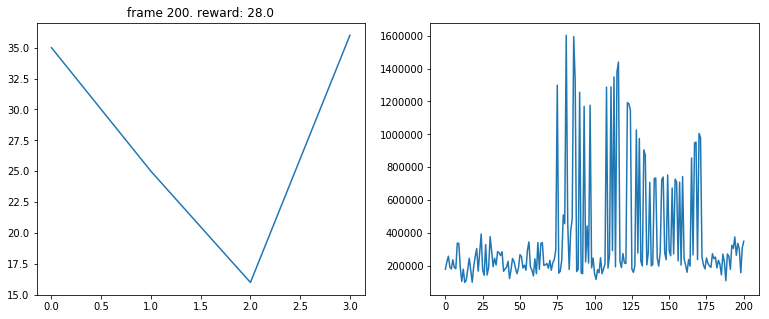

In [56]:
num_episodes = 200
batch_size = 32

gamma= 0.99

losses= []

all_rewards = []

episode_reward = 0


state =env.reset()

for frame_idx in range( num_episodes + 1): 
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state,  reward, done, _ = env.step(action)
    replaymemory.push(state, action, reward, next_state, done )
    
    state= next_state
    
    episode_reward += reward
    
    if done : 
        state= env.reset()
        all_rewards.append(episode_reward)
        episode_reward=0
        
    if len(replaymemory) > batch_size: 
        loss= compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 100== 0:
        plot(frame_idx, all_rewards, losses)
    